In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

import numpy as np

from copy import copy, deepcopy

print(tf.__version__)

1.12.0


Data read-in in read_part_class.ipynb, utilize results here:

In [2]:
%run read_part_class_clean.ipynb

In [3]:
print(len(gen_id_ee_raw))
sizes_ee = []
for i in range(0,len(gen_id_ee_raw)):
    sizes_ee.append(len(gen_id_ee_raw[i]))
print(np.amax(sizes_ee))

print(len(gen_id_bb_raw))
sizes_bb = []
for i in range(0,len(gen_id_bb_raw)):
    sizes_bb.append(len(gen_id_bb_raw[i]))
print(np.amax(sizes_bb))

2574
1318
7130
1580


In [4]:
max_len = -1

if (np.amax(sizes_ee)) >= (np.amax(sizes_bb)):
    max_len = np.amax(sizes_ee)
else:
    max_len = np.amax(sizes_bb)

print(max_len)

1580


Select final state particles, i.e., gen_status = 91

Find the index of this for each row -- filter out previous particles by copying array starting at index of first status = 91 particle (all following this index are status = 91 aprticles as well), however we want gen_id, so this is what we copy. (**tl;dr** -- copying gen_id of particles that are final state, find such by finding where gen_status = 91 starts)

Also need to pad input so that arrays are all same size (will needed for later when combining anyways):

In [5]:
gen_id_ee = np.array([0]*max_len)

for row in range(0,len(gen_id_ee_raw)):
    first_index = np.where(gen_status_ee_raw[row]==91)[0][0]
    gen_id_ee_cpy = deepcopy(gen_id_ee_raw[row][first_index:])
    gen_id_ee_cpy_pad = np.pad(gen_id_ee_cpy, (0, max_len - len(gen_id_ee_cpy)%max_len), 'constant')
    gen_id_ee = np.vstack((gen_id_ee, gen_id_ee_cpy_pad))

print(gen_id_ee)

[[   0    0    0 ...    0    0    0]
 [ 211  211 -211 ...    0    0    0]
 [2212  211 -211 ...    0    0    0]
 ...
 [ 130 -211  211 ...    0    0    0]
 [ 211 -211  211 ...    0    0    0]
 [ 130  211 -211 ...    0    0    0]]


In [6]:
gen_id_bb = np.array([0]*max_len)

for row in range(0,len(gen_id_bb_raw)):
    first_index = np.where(gen_status_bb_raw[row]==91)[0][0]
    gen_id_bb_cpy = deepcopy(gen_id_bb_raw[row][first_index:])
    gen_id_bb_cpy_pad = np.pad(gen_id_bb_cpy, (0, max_len - len(gen_id_bb_cpy)%max_len), 'constant')
    gen_id_bb = np.vstack((gen_id_bb, gen_id_bb_cpy_pad))

print(gen_id_bb)

[[    0     0     0 ...     0     0     0]
 [  211  -211  -211 ...     0     0     0]
 [  211  -211  -211 ...     0     0     0]
 ...
 [ -211   211 -2212 ...     0     0     0]
 [  211   211  -211 ...     0     0     0]
 [  211  -211   211 ...     0     0     0]]


Make class names / tags for jets:

In [7]:
class_names = ['Z_ee_jet', 'Z_bb_jet']
print(class_names)
Z_ee_jet = np.array([0]*len(gen_id_ee))
Z_bb_jet = np.array([1]*len(gen_id_bb))

print(Z_ee_jet)
print(len(Z_ee_jet))
print(Z_ee_jet.shape)
print(len(gen_id_ee))
print(gen_id_ee.shape)

print(Z_bb_jet)
print(len(Z_bb_jet))
print(Z_bb_jet.shape)
print(len(gen_id_bb))
print(gen_id_bb.shape)

['Z_ee_jet', 'Z_bb_jet']
[0 0 0 ... 0 0 0]
2575
(2575,)
2575
(2575, 1580)
[1 1 1 ... 1 1 1]
7131
(7131,)
7131
(7131, 1580)


(Quick visual check of ID distribution)

In [8]:
# id_bins = np.linspace(-300,300,301)
# plt.hist(x=gen_id_ee.flatten(), bins=id_bins, log=True, density=True)

# plt.show()

Start to build network:

**Directions: Comment- or uncomment- out various combinations of layers (can vary nodes as well) for various final accuracy**

In [9]:
model = keras.Sequential([
#     keras.layers.Dense(256, activation=tf.nn.tanh),
#     keras.layers.LeakyReLU(alpha=0.3),
    keras.layers.Dense(256, activation=tf.nn.relu),
    keras.layers.Dense(16, activation=tf.nn.softmax),
#     keras.layers.Dense(1, activation=tf.nn.sigmoid)
#     keras.layers.Dense(1)
])

Choice of loss='sparse_categorical_crossentropy' which expects integer labels

In [10]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
#               loss='binary_crossentropy',
              metrics=['acc'])

Will split up for testing vs. validation:

In [11]:
print(len(gen_id_ee))
print(len(gen_id_ee)/2)

print(len(gen_id_bb))
print(len(gen_id_bb)/2)

half_ee = int(len(gen_id_ee)/2)
half_bb = int(len(gen_id_bb)/2)

print(half_ee)
print(half_bb)

# data
x_val_ee = gen_id_ee[:half_ee]
partial_x_train_ee = gen_id_ee[half_ee:]

x_val_bb = gen_id_bb[:half_bb]
partial_x_train_bb = gen_id_bb[half_bb:]

# labels of data
y_val_ee = Z_ee_jet[:half_ee]
partial_y_train_ee = Z_ee_jet[half_ee:]

y_val_bb = Z_bb_jet[:half_bb]
partial_y_train_bb = Z_bb_jet[half_bb:]

2575
1287.5
7131
3565.5
1287
3565


Double check lengths of input data & labels (ee):

In [12]:
print(len(x_val_ee))
print(len(partial_x_train_ee))
print(len(x_val_ee[0]))
print(len(partial_x_train_ee[0]))
print(x_val_ee.shape)
print(partial_x_train_ee.shape)
print(y_val_ee)
print(partial_y_train_ee)
print(y_val_ee.shape)
print(partial_y_train_ee.shape)

1287
1288
1580
1580
(1287, 1580)
(1288, 1580)
[0 0 0 ... 0 0 0]
[0 0 0 ... 0 0 0]
(1287,)
(1288,)


Double check lengths of input data & labels (bb):

In [13]:
print(len(x_val_bb))
print(len(partial_x_train_bb))
print(len(x_val_bb[0]))
print(len(partial_x_train_bb[0]))
print(x_val_bb.shape)
print(partial_x_train_bb.shape)
print(y_val_bb)
print(partial_y_train_bb)
print(y_val_bb.shape)
print(partial_y_train_bb.shape)

3565
3566
1580
1580
(3565, 1580)
(3566, 1580)
[1 1 1 ... 1 1 1]
[1 1 1 ... 1 1 1]
(3565,)
(3566,)


Combine ee and bb for feading to network:

In [14]:
x_val = np.vstack((x_val_ee, x_val_bb))
y_val = np.concatenate((y_val_ee, y_val_bb), axis=None)

partial_x_train = np.vstack((partial_x_train_ee, partial_x_train_bb))
partial_y_train = np.concatenate((partial_y_train_ee, partial_y_train_bb))

print(partial_y_train)
print(len(partial_y_train))

[0 0 0 ... 1 1 1]
4854


Train model, monitor the model's loss and accuracy on samples from the validation set:

In [15]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=30,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 4854 samples, validate on 4852 samples
Epoch 1/30
4854/4854 [==============================] - 1s 140us/step - loss: 11.6445 - acc: 0.2703 - val_loss: 7.8862 - val_acc: 0.5037
Epoch 2/30
4854/4854 [==============================] - 0s 97us/step - loss: 5.5192 - acc: 0.6545 - val_loss: 4.6165 - val_acc: 0.7121
Epoch 3/30
4854/4854 [==============================] - 0s 98us/step - loss: 4.6256 - acc: 0.7122 - val_loss: 4.4107 - val_acc: 0.7249
Epoch 4/30
4854/4854 [==============================] - 0s 95us/step - loss: 4.3704 - acc: 0.7283 - val_loss: 4.3755 - val_acc: 0.7277
Epoch 5/30
4854/4854 [==============================] - 0s 97us/step - loss: 4.3318 - acc: 0.7311 - val_loss: 4.3929 - val_acc: 0.7271
Epoch 6/30
4854/4854 [==============================] - 0s 97us/step - loss: 4.3253 - acc: 0.7316 - val_loss: 4.3557 - val_acc: 0.7292
Epoch 7/30
4854/4854 [==============================] - 0s 96us/step - loss: 4.3051 - acc: 0.7326 - val_loss: 4.3262 - val_acc: 0.7315
Epoch

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  404736    
_________________________________________________________________
dense_1 (Dense)              multiple                  4112      
Total params: 408,848
Trainable params: 408,848
Non-trainable params: 0
_________________________________________________________________


Check loss and accuracy over epochs:

In [17]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

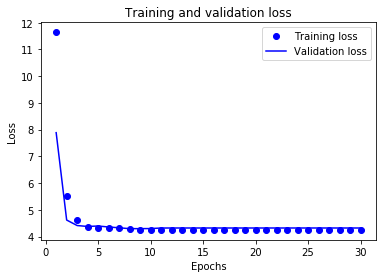

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

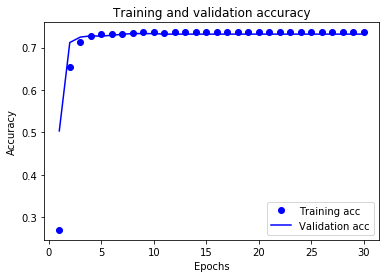

In [19]:
plt.clf()   # clear figure

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [20]:
test_predictions = model.predict(x_val)
print(test_predictions)

[[0.05707508 0.10275795 0.05940264 ... 0.06137131 0.05962342 0.06014067]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 ...
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]]
